# Summary: 

We study the modified lunar lander problem. The original problem returns a cumulative reward of the agent given a certain randomly initialized environment. The modified problem wants to evaluate the agent's performance across a range of environments. This is a multi-outcome problem where the number of outcomes is the number of different environments. By default we randomly initialize 50 environments.

We design the utility function with the following idea in mind: reward > 200 is considered good / acceptable. Thus, we create a sigmoid function that equals 0.5 when input is 200. The utility of the 50 envrionments is the sum of the 50 individal sigmoid functions. 


In [8]:
%load_ext autoreload
%autoreload 2

import itertools
import pickle
import re
import warnings
from collections import defaultdict
from dataclasses import asdict, dataclass
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import torch 

warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
outputs = torch.load('../1201_lunar_lander_results_lkj')

In [20]:
BASE_CONFIG = {
    "initial_experimentation_batch": 16,
    "n_check_post_mean": 13,
    "every_n_comps": 3,
}

In [61]:
colors_dict = {
    "pca": "tab:red", 
    "st": "tab:blue", 
    "random_linear_proj": "tab:green", 
    "random_subset": "tab:orange", 
    "mtgp": "tab:purple", 
    "lmc1": "tab:pink",
    "lmc2": "tab:brown"
    }
linestyle_dict = {"Random-f": "--", "EUBO-zeta": "-"}
marker_dict = {"$EUBO-\zeta$": "o", "True Utility": "s", "Random-f": "^"}

In [30]:
# NUM_TRIALS = 100
NUM_TRIALS = 5

problem_names = [50]


# Plot final candidate quality

In [29]:
len(outputs[50])

5

Text(0, 0.5, 'Utility of final candidate')

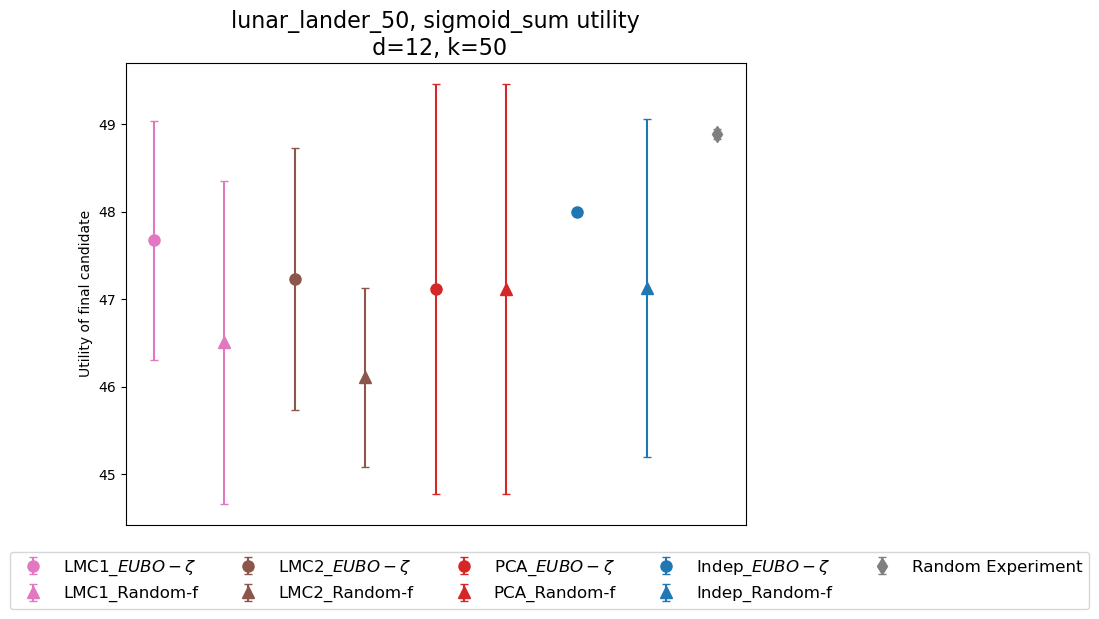

In [69]:
f, axs = plt.subplots(1, 1, figsize=(8, 6))
labels_dict = {
    "st": "Indep", "pca": "PCA", "random_linear_proj": "Rand-linear-proj", 
    "random_subset": "Rand-subset", "mtgp": "MTGP", "lmc1": "LMC1", "lmc2": "LMC2"
    }


every_n_comps = BASE_CONFIG["every_n_comps"]
n_check_post_mean = BASE_CONFIG["n_check_post_mean"]
problem_name = 'lunar_lander_50'
util_func_name = 'sigmoid_sum'
input_dim = 12
outcome_dim = 50

exp_candidate_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["exp_candidate_results"]]

exp_candidate_results_random = []
exp_candidate_results_nonrandom = []

for res in exp_candidate_results:
    if res["strategy"] == "Random Experiment":
        exp_candidate_results_random.append(res)
    else:
        exp_candidate_results_nonrandom.append(res)

# Prepare the 2nd experimentation batch data for plot
exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
exp_df["strategy"] = pd.Categorical(
    # exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
    exp_df["strategy"],
    ["True Utility", "$EUBO-\zeta$", "Random-f"],
)
# exp_df.reindex(['st', 'pca', 'random_linear_proj'], level='method')

exp_df = (
    exp_df.groupby(["method", "strategy"], sort=False)
    .agg({"candidate_util": ["mean", "sem"]})
    # .agg({"time_consumed": ["mean", "sem"]})
    .droplevel(level=0, axis=1)
    .reset_index()
)

exp_df_random = pd.DataFrame(exp_candidate_results_random)
exp_df_random = (
    exp_df_random.groupby(["strategy"])
    .agg({"candidate_util": ["mean", "sem"]})
    .droplevel(level=0, axis=1)
    .reset_index()
)

for name, group in exp_df.groupby(["method", "strategy"]):

    if group["method"].values[0] == 'mtgp':
        continue

    if group["strategy"].values[0] in ["$EUBO-\zeta$", "Random-f"]:

        axs.errorbar(
            x=[group["method"].values[0] + "_" + group["strategy"].values[0]],
            y=group["mean"],
            yerr=1.96 * group["sem"],
            fmt=marker_dict[name[1]],
            markersize=8,
            label=labels_dict[group["method"].values[0]] + "_" + group["strategy"].values[0],
            linewidth=1.5,
            capsize=3,
            color=colors_dict[name[0]],
            # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
        )

# TODO: plot random experiment result
axs.errorbar(
    x=exp_df_random["strategy"],
    y=exp_df_random["mean"],
    yerr=1.96 * exp_df_random["sem"],
    fmt="d",
    markersize=8,
    label="Random Experiment",
    linewidth=1.5,
    capsize=3,
    color="tab:grey",
)

axs.set_title(
    f"{problem_name}, {util_func_name} utility\n d={input_dim}, k={outcome_dim}", fontsize=16
)
axs.set_xticks([])

axs.legend(bbox_to_anchor=(-0.2, -0.2), loc="lower left", ncol=5, fontsize=12)
axs.set_ylabel("Utility of final candidate")

# plt.savefig(f'BOPE_real_EUBO_randomf.pdf', bbox_inches = "tight")

# 4. Plot quality of candidate over BOPE comparisons

In [56]:
def plot_candidate_over_comps(problem_names, pe_strategy, methods = ["st", "pca", "random_linear_proj", "random_subset", "mtgp"]):

    f, axs = plt.subplots(1, 1, figsize=(8, 6))
    colors_dict = {
        "pca": "tab:red",
        "st": "tab:blue",
        "random_linear_proj": "tab:green",
        "random_subset": "tab:orange",
        "mtgp": "tab:purple",
        "lmc1": "tab:pink",
        "lmc2": "tab:brown"
    }
    x_jitter_dict = {"pca": 0.1, "st": 0, "random_linear_proj": 0.2, "random_subset": 0.3, "mtgp": 0.75, "lmc1": 0.4, "lmc2": 0.5}
    labels_dict = {
        "st": "Indep", "pca": "PCA", "random_linear_proj": "Rand-linear-proj", 
        "random_subset": "Rand-subset", "mtgp": "MTGP", "lmc1": "LMC1", "lmc2": "LMC2"
        }

    every_n_comps = BASE_CONFIG["every_n_comps"]
    n_check_post_mean = BASE_CONFIG["n_check_post_mean"]
    problem_name = 'lunar_lander_50'
    util_func_name = 'sigmoid_sum'
    input_dim = 12
    outcome_dim = 50

    within_session_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["within_session_results"]]

    within_df = pd.DataFrame(within_session_results)

    within_df["pe_strategy"] = within_df["pe_strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
    within_df = (
        within_df.groupby(["n_comps", "method", "pe_strategy"])
        .agg({"util": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    for name, group in within_df.groupby(["method", "pe_strategy"]):
        if name[1] == pe_strategy:
            if name[0] in methods:

                jitter = x_jitter_dict[group["method"].values[0]]
                x_jittered = [x_ + jitter for x_ in group["n_comps"].values]

                axs.errorbar(
                    x=x_jittered,
                    y=group["mean"].values,
                    yerr=1.96 * group["sem"],
                    # label="_".join(name),
                    label=labels_dict[name[0]],
                    linewidth=1.5,
                    capsize=3,
                    alpha=0.6,
                    color=colors_dict[name[0]],
                )

                # ax1.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))

                axs.set_xlabel("Number of comparisons")
                axs.set_title(
                    f"{problem_name}, {util_func_name} utility\n d={input_dim}, k={outcome_dim}", fontsize=16
                )

    axs.set_ylabel("True utility of estimated \n utility-maximizing design")
    axs.legend(loc="lower left", ncol=5, fontsize=15)

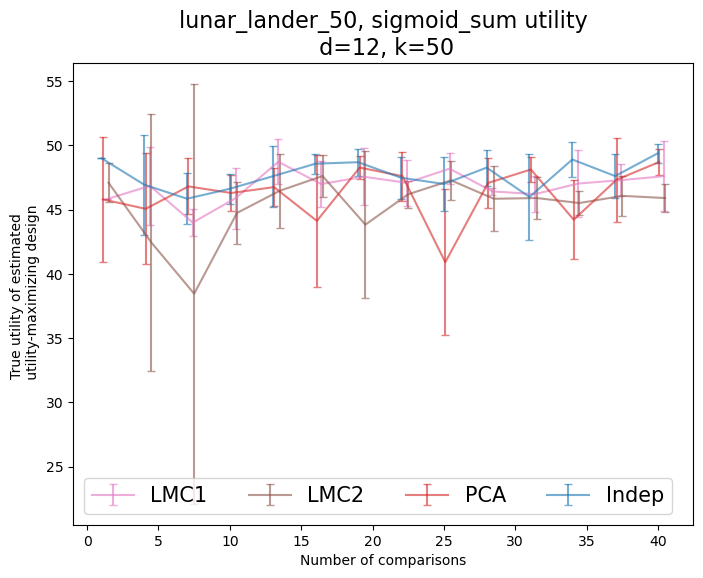

In [57]:
plot_candidate_over_comps(problem_names, 'Random-f', methods = ["st", "pca", "lmc1", "lmc2"])
# plt.savefig(f'BOPE_real_cand_progression.pdf', bbox_inches = "tight")

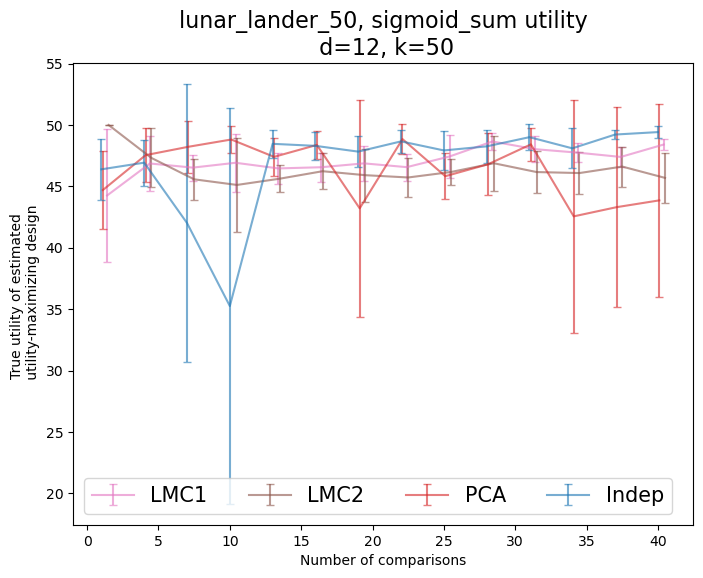

In [58]:
plot_candidate_over_comps(problem_names, "$EUBO-\zeta$", methods = ["st", "pca", "lmc1", "lmc2"])
# plt.savefig(f'BOPE_real_cand_progression_EUBO.pdf', bbox_inches = "tight")

# 3. Plot outcome and preference prediction accuracy

The goal is to understand the performance at intermediate steps within the BOPE procedure. This helps us understand the different methods better (why they are good / bad)

Text(0, 0.5, 'Preference model accuracy')

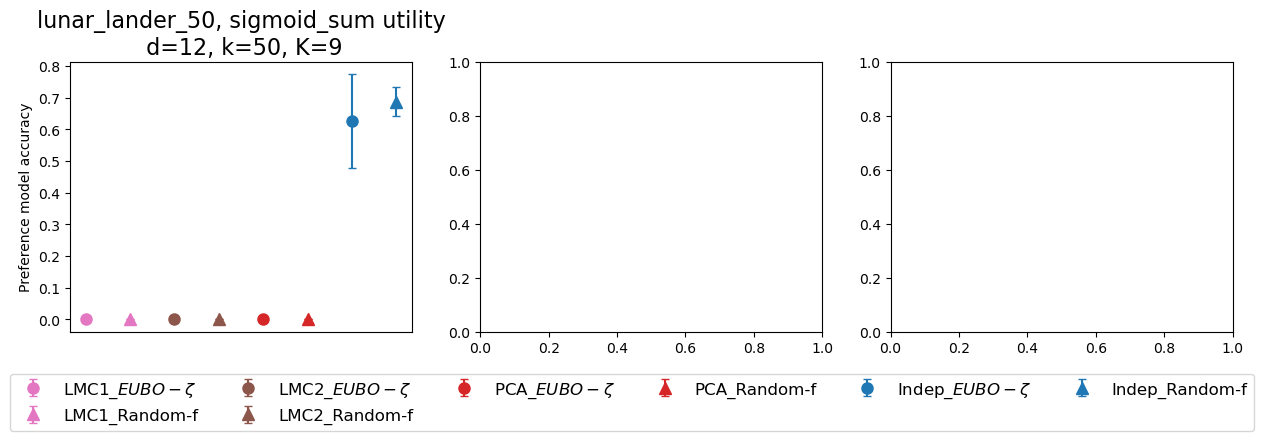

In [41]:
f, axs = plt.subplots(1, 3, figsize=(15, 3.5))
labels_dict = {
    "st": "Indep", "pca": "PCA", "random_linear_proj": "Rand-linear-proj", 
    "random_subset": "Rand-subset", "mtgp": "MTGP", "lmc1": "LMC1", "lmc2": "LMC2"
    }
    
for i in range(len(problem_names)):
    problem = problem_names[i]

    every_n_comps = BASE_CONFIG["every_n_comps"]
    n_check_post_mean = BASE_CONFIG["n_check_post_mean"]
    problem_name = 'lunar_lander_50'
    util_func_name = 'sigmoid_sum'
    input_dim = 12
    outcome_dim = 50

    exp_candidate_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["exp_candidate_results"]]

    exp_candidate_results_random = []
    exp_candidate_results_nonrandom = []

    for res in exp_candidate_results:
        if res["strategy"] == "Random Experiment":
            exp_candidate_results_random.append(res)
        else:
            exp_candidate_results_nonrandom.append(res)

    # Prepare the 2nd experimentation batch data for plot
    exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
    exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
    exp_df["strategy"] = pd.Categorical(
        # exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
        exp_df["strategy"],
        ["True Utility", "$EUBO-\zeta$", "Random-f"],
    )
    # exp_df.reindex(['st', 'pca', 'random_linear_proj'], level='method')

    exp_df = (
        exp_df.groupby(["method", "strategy"], sort=False)
        # .agg({"candidate_util": ["mean", "sem"]})
        .agg({"pref_model_acc": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    for name, group in exp_df.groupby(["method", "strategy"]):

        if group["method"].values[0] == 'mtgp':
            continue

        if group["strategy"].values[0] in ["$EUBO-\zeta$", "Random-f"]:

            axs[i].errorbar(
                x=[group["method"].values[0] + "_" + group["strategy"].values[0]],
                y=group["mean"],
                yerr=1.96 * group["sem"],
                fmt=marker_dict[name[1]],
                markersize=8,
                label=labels_dict[group["method"].values[0]] + "_" + group["strategy"].values[0],
                linewidth=1.5,
                capsize=3,
                color=colors_dict[name[0]],
                # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
            )

    # axs[i].set_xlabel("Transform + PE Strategy")
    # plt.ylabel("Utility achieved in the 2nd experiment stage")
    axs[i].set_title(
        f"{problem_name}, {util_func_name} utility\n d={input_dim}, k={outcome_dim}, K={augmented_dim}", fontsize=16
    )
    # plt.suptitle(
    #     f"\n {1 + every_n_comps * n_check_post_mean} comps, (outcome,augmented)-dim=({outcome_dim},{augmented_dim})",
    #     fontsize=20,
    # )
    axs[i].set_xticks([])

axs[0].legend(bbox_to_anchor=(-0.2, -0.4), loc="lower left", ncol=6, fontsize=12)
axs[0].set_ylabel("Preference model accuracy")

# plt.savefig(f'BOPE_real_EUBO_randomf.pdf', bbox_inches = "tight")

Text(0, 0.5, 'Outcome model mse')

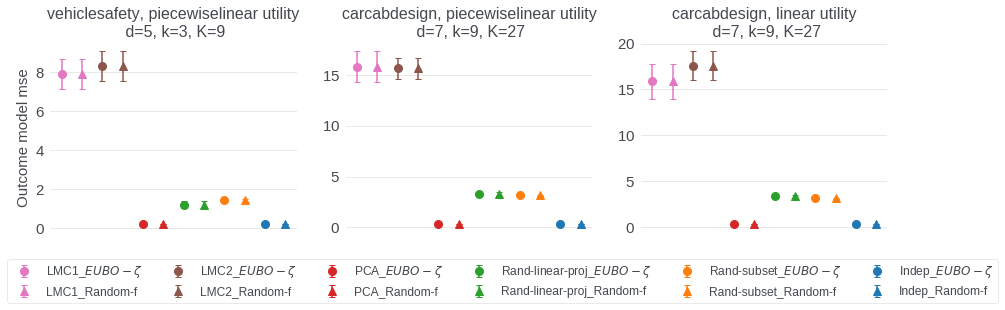

In [12]:
f, axs = plt.subplots(1, 3, figsize=(15, 3.5))
labels_dict = {
    "st": "Indep", "pca": "PCA", "random_linear_proj": "Rand-linear-proj", 
    "random_subset": "Rand-subset", "mtgp": "MTGP", "lmc1": "LMC1", "lmc2": "LMC2"
    }
    
for i in range(len(problem_names)):
    problem = problem_names[i]

    every_n_comps = BASE_CONFIG["every_n_comps"]
    n_check_post_mean = BASE_CONFIG["n_check_post_mean"]
    problem_name = problem.split("_")[0]
    util_func_name = problem.split("_")[2]
    input_dim = int(problem.split("_")[1][0])
    outcome_dim = int(problem.split("_")[1][-2])
    augmented_dim = int(problem.split("_")[-1][:-1]) * outcome_dim

    exp_candidate_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["exp_candidate_results"]]

    exp_candidate_results_random = []
    exp_candidate_results_nonrandom = []

    for res in exp_candidate_results:
        if res["strategy"] == "Random Experiment":
            exp_candidate_results_random.append(res)
        else:
            exp_candidate_results_nonrandom.append(res)

    # Prepare the 2nd experimentation batch data for plot
    exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
    exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
    exp_df["strategy"] = pd.Categorical(
        # exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
        exp_df["strategy"],
        ["True Utility", "$EUBO-\zeta$", "Random-f"],
    )
    # exp_df.reindex(['st', 'pca', 'random_linear_proj'], level='method')

    exp_df = (
        exp_df.groupby(["method", "strategy"], sort=False)
        # .agg({"candidate_util": ["mean", "sem"]})
        .agg({"outcome_model_mse": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    for name, group in exp_df.groupby(["method", "strategy"]):

        if group["method"].values[0] == 'mtgp':
            continue

        if group["strategy"].values[0] in ["$EUBO-\zeta$", "Random-f"]:

            axs[i].errorbar(
                x=[group["method"].values[0] + "_" + group["strategy"].values[0]],
                y=group["mean"],
                yerr=1.96 * group["sem"],
                fmt=marker_dict[name[1]],
                markersize=8,
                label=labels_dict[group["method"].values[0]] + "_" + group["strategy"].values[0],
                linewidth=1.5,
                capsize=3,
                color=colors_dict[name[0]],
                # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
            )

    # axs[i].set_xlabel("Transform + PE Strategy")
    # plt.ylabel("Utility achieved in the 2nd experiment stage")
    axs[i].set_title(
        f"{problem_name}, {util_func_name} utility\n d={input_dim}, k={outcome_dim}, K={augmented_dim}", fontsize=16
    )
    # plt.suptitle(
    #     f"\n {1 + every_n_comps * n_check_post_mean} comps, (outcome,augmented)-dim=({outcome_dim},{augmented_dim})",
    #     fontsize=20,
    # )
    axs[i].set_xticks([])

axs[0].legend(bbox_to_anchor=(-0.2, -0.4), loc="lower left", ncol=6, fontsize=12)
axs[0].set_ylabel("Outcome model mse")

# plt.savefig(f'BOPE_real_EUBO_randomf.pdf', bbox_inches = "tight")

Problem 50


AttributeError: 'int' object has no attribute 'split'

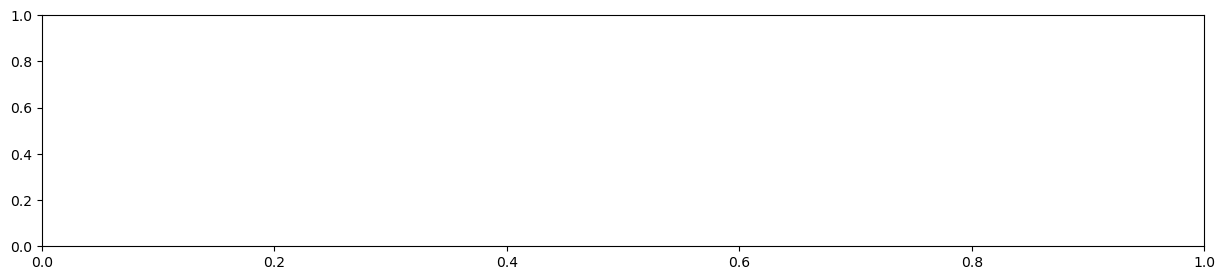

In [59]:
problem_setup_names = [
    "vehiclesafety_5d3d_piecewiselinear_3c",
    "carcabdesign_7d9d_piecewiselinear_3c",
    "carcabdesign_7d9d_linear_3c",
]
pe_strategy = 'Random-f'
methods = ["st", "pca", "random_linear_proj", "random_subset", "mtgp", "lmc"]

f, axs = plt.subplots(1, len(problem_names), figsize=(15, 3))
colors_dict = {
    "pca": "tab:red",
    "st": "tab:blue",
    "random_linear_proj": "tab:green",
    "random_subset": "tab:orange",
    "mtgp": "tab:purple",
    "lmc": "tab:pink"
}
x_jitter_dict = {"pca": 0.15, "st": 0, "random_linear_proj": 0.3, "random_subset": 0.45, "mtgp": 0.75, "lmc": 0.6}
labels_dict = {
    "pca": "PCA",
    "st": "Indep",
    "random_linear_proj": "Rand-linear-proj",
    "random_subset": "Rand-subset",
    "mtgp": "MTGP",
    "lmc": "LMC"
}


# outcome_dim = test_configs[config_name]["outcome_dim"]
# latent_dim = test_configs[config_name]["latent_dim"]

for j in range(len(problem_names)):

    problem = problem_names[j]

    print('Problem', problem)

    problem_name = problem.split("_")[0]
    util_func_name = problem.split("_")[2]
    input_dim = int(problem.split("_")[1][0])
    outcome_dim = int(problem.split("_")[1][-2])
    augmented_dim = int(problem.split("_")[-1][:-1]) * outcome_dim

    # exp_candidate_results = [outputs[problem][j]['exp_candidate_results'] for j in range(NUM_TRIALS)]
    exp_candidate_results_l = []
    exp_candidate_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["exp_candidate_results"]]


    for res in exp_candidate_results:
        if res["strategy"] == pe_strategy:
            exp_candidate_results_l.append(res)

    # Prepare the 2nd experimentation batch data for plot
    exp_df = pd.DataFrame(exp_candidate_results_l)

    exp_df_time = (
        exp_df.groupby(["method", "strategy"])
        .agg({"time_consumed": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    print('time consumed \n ', exp_df_time)

    exp_df_outcome_mse = (
        exp_df.groupby(["method", "strategy"])
        .agg({"outcome_model_mse": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    print('outcome mse \n ', exp_df_outcome_mse)

#     within_df["pe_strategy"] = within_df["pe_strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
#     within_df = (
#         within_df.groupby(["n_comps", "method", "pe_strategy"])
#         .agg({"util": ["mean", "sem"]})
#         .droplevel(level=0, axis=1)
#         .reset_index()
#     )

#     for name, group in within_df.groupby(["method", "pe_strategy"]):
#         if name[1] == pe_strategy:
#             if name[0] in methods:

#                 jitter = x_jitter_dict[group["method"].values[0]]
#                 x_jittered = [x_ + jitter for x_ in group["n_comps"].values]

#                 axs[j].errorbar(
#                     x=x_jittered,
#                     y=group["mean"].values,
#                     yerr=1.96 * group["sem"],
#                     # label="_".join(name),
#                     label=labels_dict[name[0]],
#                     linewidth=1.5,
#                     capsize=3,
#                     alpha=0.6,
#                     color=colors_dict[name[0]],
#                 )

#                 # ax1.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))

#                 axs[j].set_xlabel("Number of comparisons")
#                 axs[j].set_title(
#                     f"{problem_name}, {util_func_name} utility\n d={input_dim}, k={outcome_dim}, K={augmented_dim}", fontsize=16
#                 )

# axs[0].set_ylabel("True utility of estimated \n utility-maximizing design")
# axs[0].legend(bbox_to_anchor=(0, -0.5), loc="lower left", ncol=5, fontsize=15)

In [ ]:
# configs = ['config_1', 'config_3', 'config_5']
strategy = "$EUBO-\\zeta$"

n_configs = len(configs)

result_dict_mean = defaultdict(list)
result_dict_sem = defaultdict(list)

# f, axs = plt.subplots(1, n_configs, figsize=(20, 4))

x_jitter_dict = {"pca": 0.01, "st": 0, "random_linear_proj": 0.005, "random_subset": 3, "mtgp": 0.015, "random_subset": 0.02, "lmc": 0.015}
labels = {
    "pca" + "_" + strategy: "PCA" + "_" + strategy,
    "st" + "_" + strategy: "Indep" + "_" + strategy,
    "random_linear_proj" + "_" + strategy: "Rand-linear-proj" + "_" + strategy,
    "mtgp" + "_" + strategy: "MTGP" + "_" + strategy,
    "random_subset" + "_" + strategy: "Rand-subset" + "_" + strategy,
}
colors_dict = {
    "pca": "tab:red", 
    "st": "tab:blue", 
    "random_linear_proj": "tab:green", 
    "random_subset": "tab:orange", 
    "mtgp": "tab:purple", 
    "lmc": "tab:pink"}
labels_dict = {
    "pca": "PCA", 
    "st": "Indep", 
    "random_linear_proj": "Rand-linear-proj", 
    "random_subset": "Rand-subset", 
    "mtgp": "MTGP",
    "lmc": "LMC"}

for i in range(n_configs):

    config = configs[i]

    every_n_comps = test_configs[config]["every_n_comps"]
    n_check_post_mean = test_configs[config]["n_check_post_mean"]
    outcome_dim = test_configs[config]["outcome_dim"]
    latent_dim = test_configs[config]["latent_dim"]

    means = defaultdict(list)

    for alpha in ALPHAS:
        config_alpha_str = config + "_" + str(alpha)

        exp_candidate_results = [
            res for j in range(NUM_TRIALS) for res in outputs[config_alpha_str][j]["exp_candidate_results"]
        ]


        exp_candidate_results_random = []
        exp_candidate_results_nonrandom = []

        for res in exp_candidate_results:

            if res["strategy"] == "Random Experiment":
                exp_candidate_results_random.append(res)
            else:
                exp_candidate_results_nonrandom.append(res)

    # Prepare the 2nd experimentation batch data for plot
    exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
    exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
    exp_df["strategy"] = pd.Categorical(
        # exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
        exp_df["strategy"],
        ["True Utility", "$EUBO-\zeta$", "Random-f"],
    )
    exp_df = (
        exp_df.groupby(["method", "strategy"])
        .agg({"time_consumed": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    for name, group in exp_df.groupby(["method", "strategy"]):

        method = name[0]

        # jitter = x_jitter_dict[method]
        # alpha_jittered = alpha + jitter

        if name[1] == strategy:

            result_dict_mean[method].append(group["mean"].values[0])
            result_dict_sem[method].append(1.96 * group["sem"].values[0])

            # axs[i].errorbar(
            #     x=[alpha_jittered],
            #     y=group["mean"],
            #     yerr=1.96 * group["sem"],
            #     fmt=marker_dict[name[1]],
            #     markersize=10,
            #     label=labels[name[0] + "_" + name[1]],
            #     linewidth=1.5,
            #     capsize=5,
            #     color=colors_dict[name[0]],
            #     # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
            # )

            # means[method].append(group["mean"].values[0])

        # labels[name[0] + "_" + name[1]] = "_nolegend_"
    

for method in result_dict_mean.keys():
    plt.errorbar(
        [10,30,50],
        result_dict_mean[method],
        result_dict_sem[method],
        markersize=10,
        label=labels_dict[method],
        linewidth=3,
        capsize=5,
        color=colors_dict[method],
    )

# axs[0].legend(bbox_to_anchor=(0, -0.32), loc="lower left", ncol=5, fontsize=12)
plt.ylabel("BOPE runtime (s)", fontsize = 25)
plt.xlabel(r'Outcome dimensionality $k$', fontsize = 25)
legend = plt.legend(fontsize=14)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.1))
legend.get_frame().set_edgecolor((1, 1, 1, 0.1))
# plt.ylim([0,750])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# plt.savefig(f'bope_runtime.pdf', bbox_inches = "tight")

In [200]:
all_results = defaultdict(list)

for problem_name in problem_names:

    pca_results_eubo = []
    pca_results_randomf = []

    for i in range(NUM_TRIALS):
        res = outputs[problem_name][i]["exp_candidate_results"]
        for d in res:
            if d["strategy"] == "Random Experiment":
                break
            if d["method"] == "pca":
                if d["strategy"] == "EUBO-zeta":
                    pca_results_eubo.append(d)

                else:
                    pca_results_randomf.append(d)

    all_results[(problem_name, "eubo")] = pca_results_eubo
    all_results[(problem_name, "randomf")] = pca_results_randomf

Text(0, 0.5, 'final candidate utility')

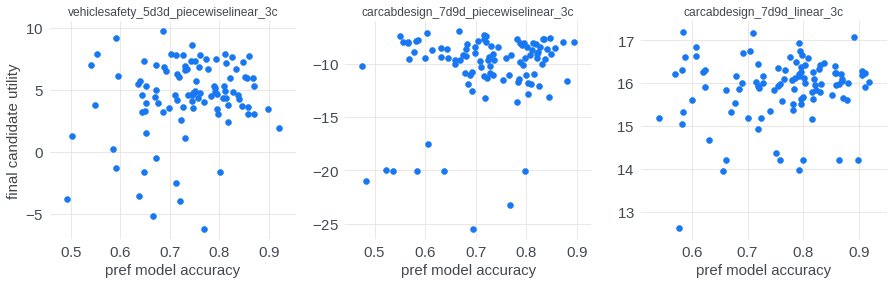

In [201]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['pref_model_acc'], pca_results_df["candidate_util"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('pref model accuracy')

axs[0].set_ylabel("final candidate utility")


Text(0, 0.5, 'pref model accuracy')

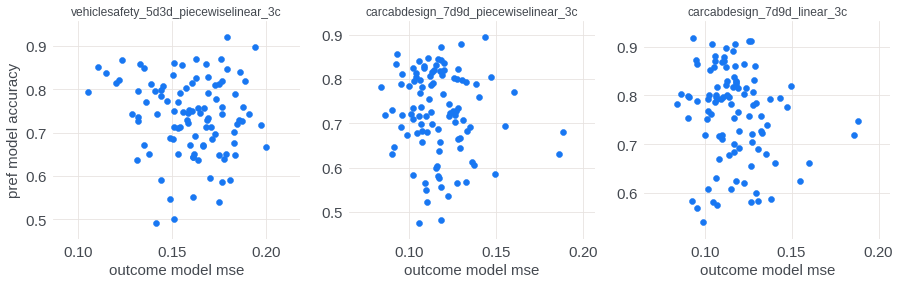

In [203]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df["outcome_model_mse"], pca_results_df["pref_model_acc"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel("outcome model mse")

axs[0].set_ylabel("pref model accuracy")

Text(0, 0.5, 'pref model accuracy')

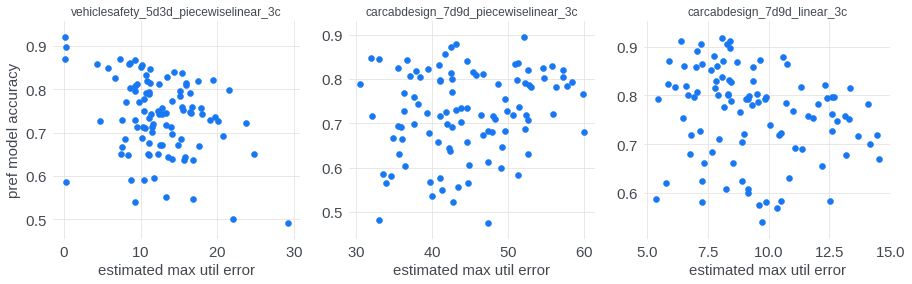

In [204]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['mc_max_util_error'], pca_results_df["pref_model_acc"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('estimated max util error')

axs[0].set_ylabel("pref model accuracy")


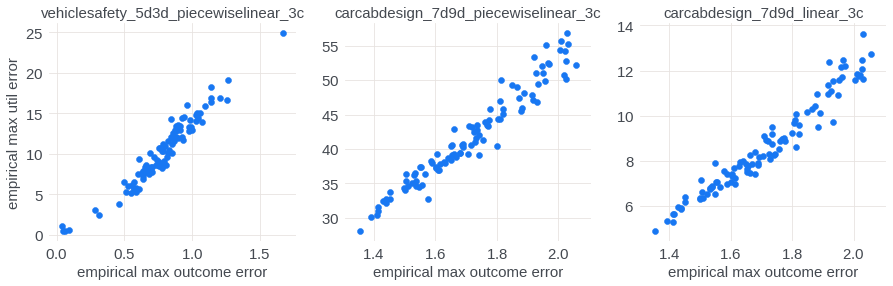

In [209]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_outcome_error'], pca_results_df["empirical_max_util_error"])
    axs[j].set_title(problem, fontsize=15)
    axs[j].set_xlabel('empirical max outcome error')

axs[0].set_ylabel("empirical max util error")

plt.savefig(f'BOPE_real_outcome_vs_util_error.pdf', bbox_inches = "tight")

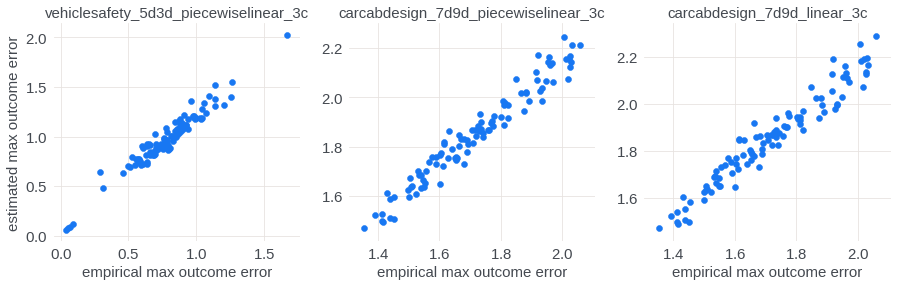

In [210]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_outcome_error'], pca_results_df["mc_max_outcome_error"])
    axs[j].set_title(problem, fontsize=15)
    axs[j].set_xlabel('empirical max outcome error')

axs[0].set_ylabel("estimated max outcome error")

plt.savefig(f'BOPE_real_outcome_error.pdf', bbox_inches = "tight")

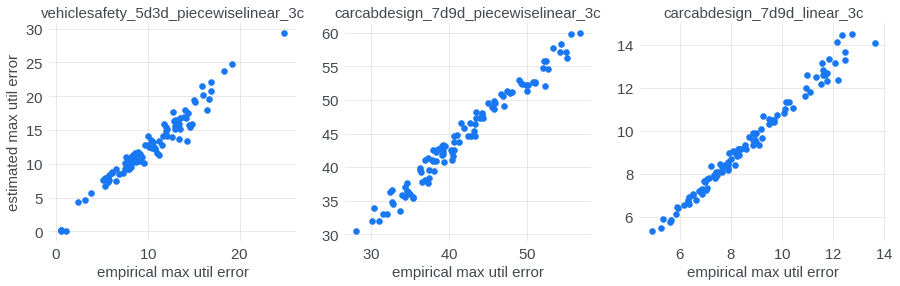

In [211]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_util_error'], pca_results_df["mc_max_util_error"])
    axs[j].set_title(problem, fontsize=15)
    axs[j].set_xlabel('empirical max util error')

axs[0].set_ylabel("estimated max util error")

plt.savefig(f'BOPE_real_util_error.pdf', bbox_inches = "tight")

Text(0, 0.5, 'final candidate utility')

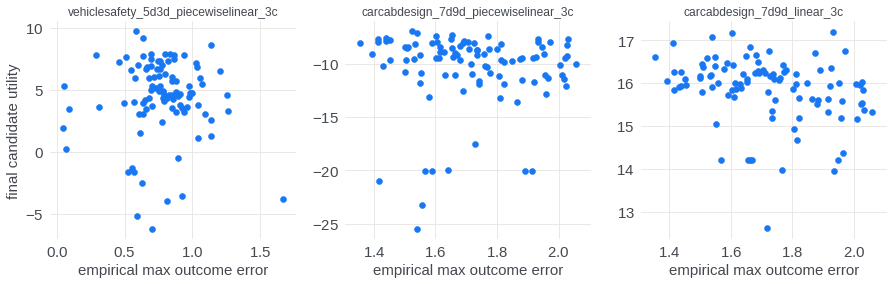

In [206]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_outcome_error'], pca_results_df["candidate_util"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('empirical max outcome error')

axs[0].set_ylabel("final candidate utility")


Text(0, 0.5, 'final candidate utility')

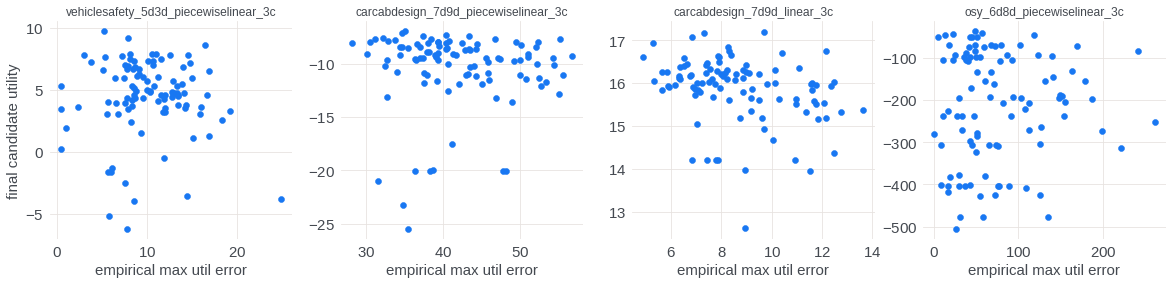

In [142]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))

for j in range(4):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_util_error'], pca_results_df["candidate_util"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('empirical max util error')

axs[0].set_ylabel("final candidate utility")


Text(0, 0.5, 'final candidate utility')

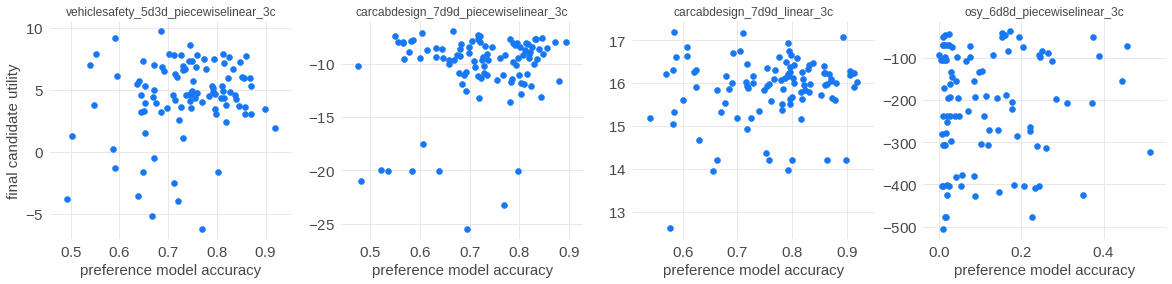

In [143]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))

for j in range(4):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['pref_model_acc'], pca_results_df["candidate_util"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('preference model accuracy')

axs[0].set_ylabel("final candidate utility")


Text(0, 0.5, 'estimated max util error')

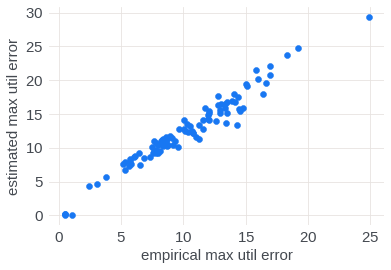

In [108]:
plt.scatter(pca_results_eubo_df['empirical_max_util_error'], pca_results_eubo_df['mc_max_util_error'])
plt.xlabel('empirical max util error')
plt.ylabel('estimated max util error')

Text(0, 0.5, 'estimated max outcome error')

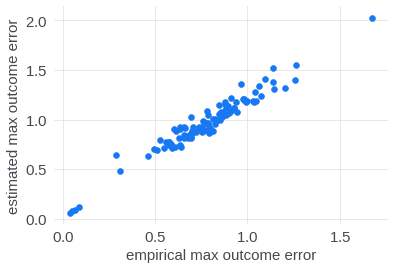

In [109]:
plt.scatter(pca_results_eubo_df['empirical_max_outcome_error'], pca_results_eubo_df['mc_max_outcome_error'])
plt.xlabel('empirical max outcome error')
plt.ylabel('estimated max outcome error')

Text(0, 0.5, 'final candidate utility')

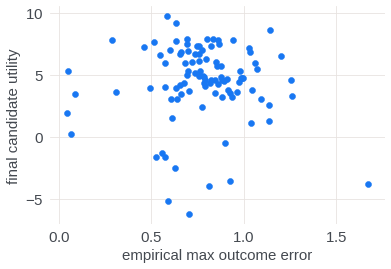

In [113]:
plt.scatter(pca_results_eubo_df["empirical_max_outcome_error"], pca_results_eubo_df["candidate_util"])
plt.xlabel("empirical max outcome error")
plt.ylabel("final candidate utility")

In [104]:
# what does the outcome distribution of OSY look like?

In [105]:
from ae.pref_el

1.5

# below not relevant for now

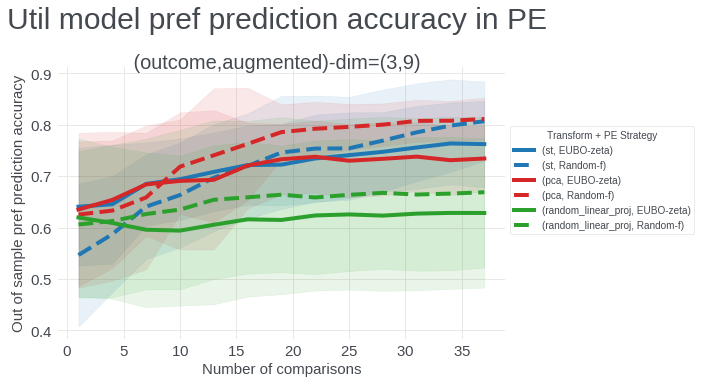

In [139]:
plt.figure(figsize=(8, 5))
for method_pe_strategy_tuple in model_accs_avg.keys():
    method, pe_strategy = method_pe_strategy_tuple
    plt.plot(
        [1 + 3 * i for i in range(13)],
        model_accs_avg[method_pe_strategy_tuple][0],  # mean
        label=f"({method}, {pe_strategy})",
        color=colors_dict[method],
        linestyle=linestyle_dict[pe_strategy],
    )
    plt.fill_between(
        [1 + 3 * i for i in range(13)],
        model_accs_avg[method_pe_strategy_tuple][0] - model_accs_avg[method_pe_strategy_tuple][1],
        model_accs_avg[method_pe_strategy_tuple][0] + model_accs_avg[method_pe_strategy_tuple][1],
        color=colors_dict[method],
        alpha=0.1,
    )
plt.legend()
plt.title("Util model pref prediction accuracy in PE \n")
plt.suptitle(f"\n (outcome,augmented)-dim=({outcome_dim},{augmented_dim})", fontsize=20)

plt.xlabel("Number of comparisons")
plt.ylabel("Out of sample pref prediction accuracy")
plt.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))


plt.savefig(f"PE_util_model_acc_{outcome_dim}_{augmented_dim}.pdf", bbox_inches="tight")

In [140]:

exp_candidate_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]['exp_candidate_results']]


exp_candidate_results_random = []
exp_candidate_results_nonrandom = []


for res in exp_candidate_results:
    if res['strategy'] == 'Random Experiment':
        exp_candidate_results_random.append(res)
    else:
        exp_candidate_results_nonrandom.append(res)


In [141]:
len(exp_candidate_results)

1000

In [142]:

# Prepare the 2nd experimentation batch data for plot
exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
exp_df["strategy"] = pd.Categorical(
    # exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
    exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f"]
)
exp_df = exp_df.groupby(["method","strategy"]).agg({"candidate_util": ["mean", "sem"]}).droplevel(level=0, axis=1).reset_index()


exp_df_random = pd.DataFrame(exp_candidate_results_random)
exp_df_random = exp_df_random.groupby(["strategy"]).agg({"candidate_util": ["mean", "sem"]}).droplevel(level=0, axis=1).reset_index()

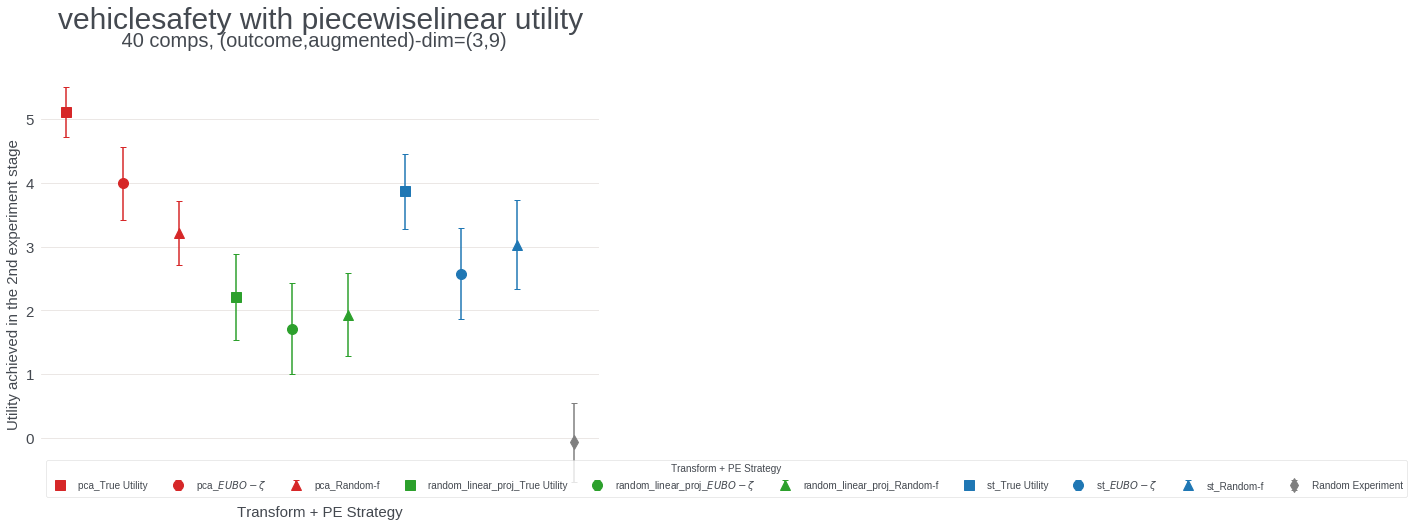

In [152]:
# Plotting
plt.figure(figsize=(10, 8))

# fig, ax = plt.subplots()


for name, group in exp_df.groupby(["method", "strategy"], sort=True):

    plt.errorbar(
        x=[group["method"].values[0] + "_" + group["strategy"].values[0]],
        y=group["mean"],
        yerr=1.96 * group["sem"],
        fmt=marker_dict[name[1]],
        markersize=10,
        label="_".join(name),
        linewidth=1.5,
        capsize=3,
        color=colors_dict[name[0]],
        # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
    )

# TODO: plot random experiment result
plt.errorbar(
    x=exp_df_random["strategy"],
    y=exp_df_random["mean"],
    yerr=1.96 * exp_df_random["sem"],
    fmt="d",
    markersize=10,
    label="Random Experiment",
    linewidth=1.5,
    capsize=3,
    color="tab:grey",
)

plt.xlabel("Transform + PE Strategy")
plt.ylabel("Utility achieved in the 2nd experiment stage")
plt.legend(title="Transform + PE Strategy", loc = 'lower left', ncol = 10)
plt.title(f"{problem_name} with {util_func_name} utility\n")
plt.suptitle(
    f"\n {1 + every_n_comps * n_check_post_mean} comps, (outcome,augmented)-dim=({outcome_dim},{augmented_dim})",
    fontsize=20,
)


plt.xticks(rotation=90)
plt.xticks([])


plt.savefig(f"final_candidate_utility_{outcome_dim}_{augmented_dim}.pdf", bbox_inches="tight")

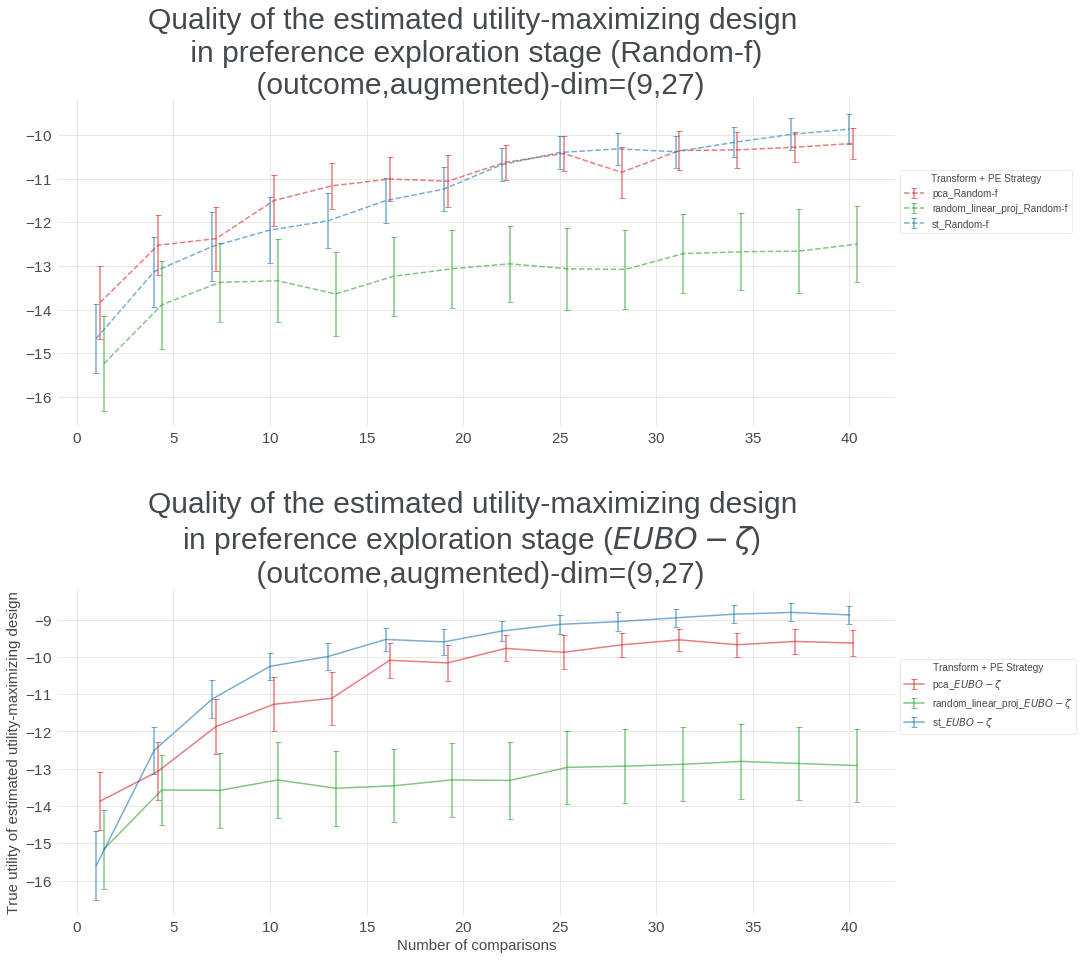

In [124]:
within_session_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["within_session_results"]]


within_df = pd.DataFrame(within_session_results)

within_df["pe_strategy"] = within_df["pe_strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
within_df = (
    within_df.groupby(["n_comps", "method", "pe_strategy"])
    .agg({"util": ["mean", "sem"]})
    .droplevel(level=0, axis=1)
    .reset_index()
)

colors_dict = {"pca": "tab:red", "st": "tab:blue", "random_linear_proj": "tab:green", "random_subset": "tab_orange"}

x_jitter_dict = {"pca": 0.2, "st": 0, "random_linear_proj": 0.4, "random_subset": 3}

# Plotting
# plt.figure(figsize=(10, 10))
f, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

for name, group in within_df.groupby(["method", "pe_strategy"], sort=True):
    if name[1] == "Random-f":
        linestyle = "--"

        jitter = x_jitter_dict[group["method"].values[0]]
        x_jittered = [x_ + jitter for x_ in group["n_comps"].values]

        ax1.errorbar(
            x=x_jittered,
            y=group["mean"].values,
            yerr=1.96 * group["sem"],
            label="_".join(name),
            linewidth=1.5,
            capsize=3,
            alpha=0.6,
            linestyle=linestyle,
            color=colors_dict[name[0]],
        )

        ax1.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))
    else:
        linestyle = "-"

        jitter = x_jitter_dict[group["method"].values[0]]
        x_jittered = [x_ + jitter for x_ in group["n_comps"].values]

        ax2.errorbar(
            x=x_jittered,
            y=group["mean"],
            yerr=1.96 * group["sem"],
            label="_".join(name),
            linewidth=1.5,
            capsize=3,
            alpha=0.6,
            linestyle=linestyle,
            color=colors_dict[name[0]],
        )

        ax2.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))


plt.xlabel("Number of comparisons")
plt.ylabel("True utility of estimated utility-maximizing design")
ax2.set_title(
    "Quality of the estimated utility-maximizing design \n"
    + r"in preference exploration stage ($EUBO-\zeta$)  "
    + f"\n (outcome,augmented)-dim=({outcome_dim},{augmented_dim})"
)
ax1.set_title(
    "Quality of the estimated utility-maximizing design \n in preference exploration stage (Random-f) "
    + f"\n (outcome,augmented)-dim=({outcome_dim},{augmented_dim})"
)


plt.savefig(f"PE_candidates_quality_{outcome_dim}_{augmented_dim}.pdf", bbox_inches="tight")